<a href="https://colab.research.google.com/github/sarcasticvibes/CRNN-for-Hindi-Text-Recognition/blob/master/CRNN_for_Hindi_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install albumentations --upgrade

     |████████████████████████████████| 122kB 4.8MB/s 
     |████████████████████████████████| 634kB 15.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=5660c0fc3922a362e2e62d1d01d5b96117011fa50077bbcd6d4bdf50e93a748d
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=ba75ce157430d608d5831e5330c88bea2de96b15af265542bcefdc6c1f4076ac
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=5c72a81cf9ba0a5715f85216bdd17c89b932b093f4f19d7cedf85ae59a42c6d2
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
! tar -xvf '/content/drive/My Drive/TransliterationDataset/cropped_data.tar'

In [66]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim

from pretrainedmodels import resnet18

import cv2
from google.colab.patches import cv2_imshow
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [6]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
pad_char = '-'
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

In [ ]:
def gt_rep(word, letter2index, device = device_gpu):
    gt_rep = torch.zeros([len(word), 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    #gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [18]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))
        self.dropout  = nn.Dropout(p=.3)


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        conv = self.dropout(conv)

        # rnn features
        output = self.rnn(conv)
        output = self.dropout(output)
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [19]:
model = CRNN(32, 3, 129, 256)

In [ ]:
model

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [10]:
import os
a = os.listdir('/content/cropped_data/cropped_dir')[0]
img = cv2.imread(f'/content/cropped_data/cropped_dir/{a}')

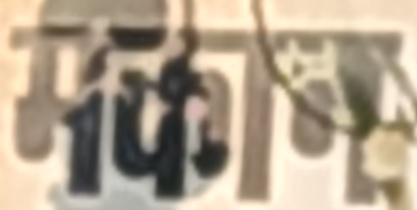

In [11]:
cv2_imshow(img)

In [9]:
def get_train_transforms():
    return A.Compose(
        [
            # A.OneOf([
            #     A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
            #                          val_shift_limit=0.2, p=0.9),
            #     A.RandomBrightnessContrast(brightness_limit=0.2, 
            #                                contrast_limit=0.2, p=0.9),
            # ],p=0.9),
            A.ToGray(p=0.01),
            A.Resize(height=50, width=200, p=1),
            A.Normalize(),
            ToTensorV2(p=1.0)
        ], 
        p=1.0, 
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=32, width=64, p=1.0),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], 
        p=1.0
    )

In [12]:
class DataLoader:
  def __init__(self, test=False):
    if test:
      self.aug = get_valid_transforms()
    else:
      self.aug = get_train_transforms()
    
    self.image_ids = [i for i in enumerate(os.listdir('/content/cropped_data/cropped_dir'))]
    with open('/content/cropped_data/annotations.txt') as f:
      gt = f.read()
      gt = list(gt.split('\n'))
      gt = list(map(str.split, gt))
      label = []
      for i, anno in enumerate(gt):
        gts = [a for a in anno]
        if(len(gts)<2):
          continue
        label.append(gts[1])
    self.labels = label
  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = cv2.imread(f'/content/cropped_data/cropped_dir/{item}.jpg')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.aug(image = np.array(image))['image']
    #image = np.transpose(image, (2, 0, 1))
    return {
        'image':image,
        'label':self.labels[item]
    }

In [15]:
dataset = DataLoader()
dataset[5]['label']

'आज्ञा'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 50, 200])

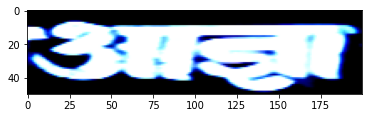

In [14]:
image = dataset[5]['image']
numpy_image = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1)
ax.imshow(numpy_image);
image.shape

In [ ]:
#Function to convert a batch of labels to coresponding represtentation that can be passed to the CRNN model
def label_rep(labels, device = device_gpu, letter2index = hindi_alpha2index):
  gt = []
  len_ = torch.zeros(len(labels), dtype=torch.long).to(device)
  for label in labels:
    gt.append(gt_rep(label, letter2index, device))
  rep = torch.zeros([len(labels),max(len(x) for x in gt) ], dtype=torch.long).to(device)
  for index, label in enumerate(gt):
    for i, char in enumerate(label):
      rep[index][i] = char
    len_[index] = len(label)
  return len_, rep

In [25]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [hindi_alpha2index[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [16]:
def compute_loss(text_batch, text_batch_logits, criterion, device=device_gpu):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [57]:
#Function to perform one training step given a batch of input images and their ground truths
#We are using CTC loss function as our loss function
def train_batch(net, opt, criterion, images, labels, device = device_gpu, batch_size = 10):
    
    net.train().to(device)
    opt.zero_grad()

    input = images
    outputs = net(input)
    loss = compute_loss(labels, outputs, criterion, device=device)
    nn.utils.clip_grad_norm_(net.parameters(), 50)
    opt.step()
    return loss

In [41]:
#Training driver function which takes the hyper parameters and works accordingly
def train_setup(net, lr = 0.0001, n_epochs = 10, batch_size =16, weight_decay=1e-3, display_freq=5, device = device_gpu):
    
    net = net.to(device)
    criterion = nn.CTCLoss(blank=0)
    opt = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', patience=5, factor=.3)
    for e in range(n_epochs):
      
      trainloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
      n_batches = len(trainloader)
      loss_arr = np.zeros(n_batches+1)

      for i, data in tqdm_notebook(enumerate(trainloader), total = n_batches, unit = "epoch"):
          images, labels = data['image'], data['label']
          
          images = torch.tensor(images, dtype=torch.float, device=device_gpu)
          loss_arr[i] = train_batch(net, opt, criterion, images, labels, device = device, batch_size = batch_size)
          
          if i%display_freq == display_freq-1:
              print('Epoch',e,'Iteration', i, 'Loss', loss_arr[:i+1].mean())
              print('\n\n')
      scheduler.step(loss_arr[i])  
    torch.save(net.state_dict(), 'model.pt')

In [49]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = True)
batch = iter(trainloader).next()
output = model(batch['image'].to(device_gpu))
#output.shape
compute_loss(batch['label'], output, criterion=nn.CTCLoss(blank=0))

tensor(9.8637, device='cuda:0', grad_fn=<MeanBackward0>)

In [52]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        resnet = resnet18(pretrained='imagenet')
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [53]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [54]:
model = CRNN(len(hindi_alpha2index))

In [55]:
model.apply(weights_init)

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
train_setup(model)

In [64]:
lr = .001
weight_decay = 1e-3

In [67]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [71]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = True)

In [77]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, 100)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for data in tqdm(train_loader, leave=False):
        image_batch = data['image']
        text_batch = data['label']

        optimizer.zero_grad()
        text_batch_logits = model(image_batch.to(device_gpu))
        loss = compute_loss(text_batch, text_batch_logits, nn.CTCLoss())
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Epoch:1    Loss:2.992346245309581    NumUpdates:92


Epoch:2    Loss:2.8688508920047595    NumUpdates:92


Epoch:3    Loss:2.7589980863755748    NumUpdates:93


Epoch:4    Loss:2.6779063214426455    NumUpdates:92


Epoch:5    Loss:2.566729540410249    NumUpdates:92


Epoch:6    Loss:2.4969700818420737    NumUpdates:93


Epoch:7    Loss:2.335058767308471    NumUpdates:93


Epoch:8    Loss:2.25314652401468    NumUpdates:92


Epoch:9    Loss:2.1491471347601516    NumUpdates:92


Epoch:10    Loss:2.028992742620489    NumUpdates:93


Epoch:11    Loss:1.928929222666699    NumUpdates:92


Epoch:12    Loss:1.8229626429841874    NumUpdates:94


Epoch:13    Loss:1.683313686360595    NumUpdates:93


Epoch:14    Loss:1.6113720659328543    NumUpdates:92


Epoch:15    Loss:1.4992820173501968    NumUpdates:92


Epoch:16    Loss:1.4206663805951354    NumUpdates:93


Epoch:17    Loss:1.2559208571910858    NumUpdates:94


Epoch:18    Loss:1.220157335633817    NumUpdates:92


Epoch:19    Loss:1.0772663675328737    NumUpdates:93


Epoch:20    Loss:1.0243895117954542    NumUpdates:93


Epoch:21    Loss:0.9755203280043094    NumUpdates:94


Epoch:22    Loss:0.8621635187056756    NumUpdates:93


Epoch:23    Loss:0.8166938689739808    NumUpdates:92


Epoch:24    Loss:0.7731299176812172    NumUpdates:92


Epoch:25    Loss:0.7456631586756758    NumUpdates:93


Epoch:26    Loss:0.6862888433363127    NumUpdates:92


Epoch:27    Loss:0.602863074934229    NumUpdates:94


Epoch:28    Loss:0.5861722643071032    NumUpdates:94


Epoch:29    Loss:0.5111060023624846    NumUpdates:94


Epoch:30    Loss:0.4874743495577125    NumUpdates:93


Epoch:31    Loss:0.4003403903015198    NumUpdates:93


Epoch:32    Loss:0.3894487002297588    NumUpdates:92


Epoch:33    Loss:0.44040002673864365    NumUpdates:92


Epoch:34    Loss:0.511191354643914    NumUpdates:93


Epoch:35    Loss:0.4599271351669697    NumUpdates:94


Epoch:36    Loss:0.3949028729431091    NumUpdates:93


Epoch:37    Loss:0.3211194137516229    NumUpdates:92


Epoch:38    Loss:0.25214046788843053    NumUpdates:95


Epoch:39    Loss:0.2720524644915094    NumUpdates:94


Epoch:40    Loss:0.2685754017964486    NumUpdates:93


Epoch:41    Loss:0.29739803232644735    NumUpdates:95


Epoch:42    Loss:0.3954413783165716    NumUpdates:93


Epoch:43    Loss:0.36270818530872306    NumUpdates:93


Epoch:44    Loss:0.3223522202942961    NumUpdates:93
Epoch    54: reducing learning rate of group 0 to 1.0000e-04.


Epoch:45    Loss:0.16458062297138182    NumUpdates:92


Epoch:46    Loss:0.10267756022112344    NumUpdates:93


Epoch:47    Loss:0.09496497045806114    NumUpdates:94


Epoch:48    Loss:0.08231353050758762    NumUpdates:93


Epoch:49    Loss:0.07659330906005957    NumUpdates:93


Epoch:50    Loss:0.07420079710502778    NumUpdates:93


Epoch:51    Loss:0.07137213203501194    NumUpdates:94


Epoch:52    Loss:0.06791662643461124    NumUpdates:92


Epoch:53    Loss:0.07014126792394866    NumUpdates:96


Epoch:54    Loss:0.06484345481433768    NumUpdates:94


Epoch:55    Loss:0.0662940669249981    NumUpdates:94


Epoch:56    Loss:0.06422861767442603    NumUpdates:95


Epoch:57    Loss:0.06295908939453863    NumUpdates:93


Epoch:58    Loss:0.06453748657665354    NumUpdates:94


Epoch:59    Loss:0.06137351211356489    NumUpdates:95


Epoch:60    Loss:0.061894778241502475    NumUpdates:94


Epoch:61    Loss:0.06003786959563908    NumUpdates:92


Epoch:62    Loss:0.062304548068862896    NumUpdates:92


Epoch:63    Loss:0.06372869377145948    NumUpdates:92


Epoch:64    Loss:0.06084654682680317    NumUpdates:92


Epoch:65    Loss:0.06152402787752773    NumUpdates:92


Epoch:66    Loss:0.06247589348625111    NumUpdates:93


Epoch:67    Loss:0.06251962715259163    NumUpdates:93
Epoch    77: reducing learning rate of group 0 to 1.0000e-05.


Epoch:68    Loss:0.05979371229676824    NumUpdates:95


Epoch:69    Loss:0.058703855060601745    NumUpdates:93


Epoch:70    Loss:0.05715480981830587    NumUpdates:94


Epoch:71    Loss:0.05642764250277191    NumUpdates:93


Epoch:72    Loss:0.05771129950881004    NumUpdates:94


Epoch:73    Loss:0.05635545655123649    NumUpdates:93


Epoch:74    Loss:0.056235862023969914    NumUpdates:94


Epoch:75    Loss:0.05662475566825141    NumUpdates:92


Epoch:76    Loss:0.056162387821013515    NumUpdates:92


Epoch:77    Loss:0.056546948269330044    NumUpdates:93


Epoch:78    Loss:0.05655088822575326    NumUpdates:94


Epoch:79    Loss:0.05710146986749223    NumUpdates:93


Epoch:80    Loss:0.05520037153074818    NumUpdates:93


Epoch:81    Loss:0.05782766820376982    NumUpdates:92


Epoch:82    Loss:0.05556518653113591    NumUpdates:95


Epoch:83    Loss:0.057319956601306954    NumUpdates:93


Epoch:84    Loss:0.05521116153367104    NumUpdates:93


Epoch:85    Loss:0.05549436884567789    NumUpdates:92


Epoch:86    Loss:0.054536072007919614    NumUpdates:95


Epoch:87    Loss:0.0560966859895574    NumUpdates:92


Epoch:88    Loss:0.05556507084158159    NumUpdates:93


Epoch:89    Loss:0.055719712789615856    NumUpdates:92


Epoch:90    Loss:0.0562334502439784    NumUpdates:92


Epoch:91    Loss:0.054440800821588885    NumUpdates:93


Epoch:92    Loss:0.05599503143829234    NumUpdates:94


Epoch:93    Loss:0.055026869860387614    NumUpdates:93


Epoch:94    Loss:0.05477530719793361    NumUpdates:92


Epoch:95    Loss:0.05576383947364746    NumUpdates:93


Epoch:96    Loss:0.056153017166321    NumUpdates:93


Epoch:97    Loss:0.05567916717968489    NumUpdates:95
Epoch   107: reducing learning rate of group 0 to 1.0000e-06.


Epoch:98    Loss:0.05504426940955141    NumUpdates:93


Epoch:99    Loss:0.054032846283848565    NumUpdates:93



In [83]:
alpha_hindi = {i:j for j, i in hindi_alpha2index.items()}

In [ ]:
alpha_hindi

In [86]:
def decode_predictions(text_batch_logits):

  text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
  text_batch_tokens = text_batch_tokens.cpu().numpy().T # [batch_size, T]

  text_batch_tokens_new = []
  for text_tokens in text_batch_tokens:
      text = [alpha_hindi
      [idx] for idx in text_tokens]
      text = "".join(text)
      text_batch_tokens_new.append(text)

  return text_batch_tokens_new